In [81]:
import sys
import pandas as pd
import numpy as np
import datetime
import requests
import numpy as np
from pandas import ExcelWriter
import os
import glob
import pytz
from dateutil.tz import gettz
import timeit
import matplotlib.pyplot as plt
import pytemperature
# from datetime import datetime
import re
from bs4 import BeautifulSoup
from datetime import timedelta
import time
pd.set_option('display.max_rows', None)

In [82]:
def read_data(devid, acc_token, address, start_time, end_time, descriptors):

    r2 = requests.get(
        url=address + "/api/plugins/telemetry/DEVICE/" + devid + "/values/timeseries?keys=" + descriptors + "&startTs=" + start_time + "&endTs=" + end_time + "&agg=NONE&limit=1000000",
        headers={'Content-Type': 'application/json', 'Accept': '*/*', 'X-Authorization': acc_token}).json()

    if r2:
        df = pd.DataFrame([])

        for desc in r2.keys():
            df1 = pd.DataFrame(r2[desc])
            df1.set_index('ts', inplace=True)
            df1.columns = [str(desc)]
            
            df1.reset_index(drop=False, inplace=True)
            df1['ts'] = pd.to_datetime(df1['ts'], unit='ms')
            df1 = df1.sort_values(by=['ts'])
            df1.reset_index(drop=True, inplace=True)
            df1.set_index('ts', inplace=True, drop=True)
            
            for col in df1.columns:
                df1[col] = df1[col].astype('float')
                
            
            df = pd.concat([df, df1], axis=1)


        if df.empty:
            df = pd.DataFrame([])
    else:
        df = pd.DataFrame([])
        print('Empty json!')
    return df


In [83]:
# Room 1
# airquality = 000.888.000126
# motionsensor = 000.888.000133
# plug = 101.301.002403

# Room 2
# airquality = 000.888.000124
# motionsensor = 000.888.000134
# plug = 101.301.002411

# Room 3
# airquality = 000.888.000125
# motionsensor = 000.888.000135
# plug = 101.301.002402

devname = '000.888.000126' 
descriptors = 'ppb,tmp,hmd'



start_time = '1620594000000'
end_time = '1622494800000'
# start_time = '1623704400000'
# end_time = '1626296400000'

address =  "https://m3.meazon.com"

r = requests.post(address + "/api/auth/login",
                  json={'username': 'a.andrikopoulos19@meazon.com', 'password': 'andrikopMeazon13'}).json()

# acc_token is the token to be used in the next request
acc_token = 'Bearer' + ' ' + r['token']

# get devid by serial name
r1 = requests.get(
    url=address + "/api/tenant/devices?deviceName=" + devname,
    headers={'Content-Type': 'application/json', 'Accept': '*/*', 'X-Authorization': acc_token}).json()

devid = r1['id']['id']

df = read_data(devid, acc_token, address, start_time, end_time, descriptors)

df = df.resample('1T').max()
df['ts'] = df.index
df['ts'] = df['ts'].dt.tz_localize('utc').dt.tz_convert('Europe/Athens')
df.set_index('ts',inplace=True,drop=True)
df = df.fillna(method='ffill')
df.loc[df['tmp']<0]= np.nan
df = df.dropna()
df['day'] = df.index.weekday
df['hour'] = df.index.hour
# df = df.loc[df['day']<5]
# df = df.loc[(df['hour']<=15) & (df['hour']>=8)]

df.drop(['day','hour'],axis=1,inplace=True)

df.loc[df['ppb']>30000,'ppb'] = df['ppb'].quantile(.5)
df.loc[df['hmd']>100,'hmd'] = df['hmd'].quantile(.5)
df.loc[df['tmp']>50,'tmp'] = df['tmp'].quantile(.5)
df.loc[df['tmp']<0,'tmp'] = df['tmp'].quantile(.5)
df.describe()

,ppb,tmp,hmd
count,26615.000000,26615.000000,26615.000000
mean,181.031862,30.647225,47.817043
std,99.188701,2.722650,4.978180
min,0.000000,26.200000,31.900000
25%,131.000000,28.100000,44.300000
50%,171.000000,30.600000,48.700000
75%,247.000000,33.400000,51.200000
max,1429.000000,35.200000,63.100000


Text(0, 0.5, 'PPB')

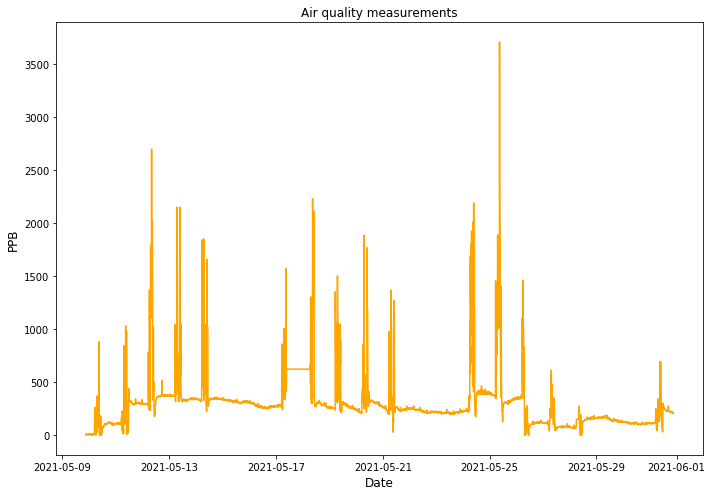

In [44]:
# fig = plt.figure(figsize=[12,8])
# plt.plot(df['Temperature'])
# plt.plot(df['Air quality'])
fig = plt.figure(figsize=[10,7])

plt.plot(df['ppb'],color='orange')
plt.title('Air quality measurements',fontsize=12)
plt.xlabel('Date',fontsize=12)
plt.ylabel('PPB',fontsize=12)

([<matplotlib.axis.XTick at 0x7f440ab1c710>,
 <a list of 12 Text xticklabel objects>)

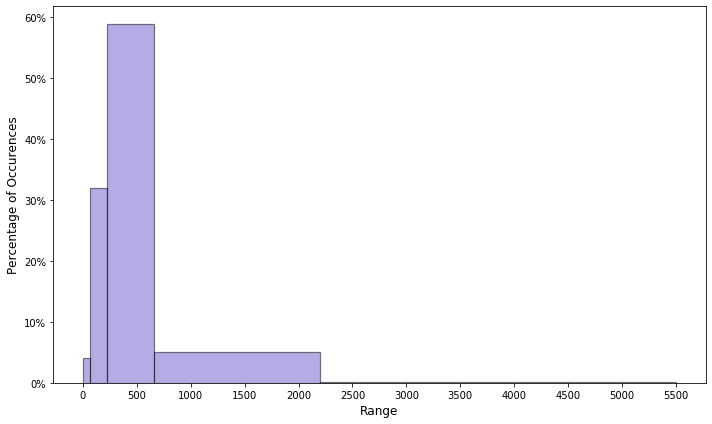

In [80]:
# hist = df['ppb'].hist(bins=[0,300,1000,3000,10000,25000])
from matplotlib.ticker import PercentFormatter
fig = plt.figure(figsize=[10,6])
plt.hist(df['ppb'], bins=[0,65,220,660,2200,5500], weights=np.ones(df.shape[0]) / df.shape[0],label='hst',alpha=0.5, linewidth=1.2,ec='black',color='slateblue')
# (n, bins, patches) = plt.hist(df['ppb'], bins=[0,300,1000,3000,10000,25000], label='hst')

plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.xlabel('Range',fontsize=12)
plt.ylabel('Percentage of Occurences',fontsize=12)
plt.xticks(np.arange(0, 5500+1, 500.0))
# sumn = np.sum(n)
# n = (n/sumn)*100
# print('n:',n)

n: [ 1265. 10123. 18641.  1587.    45.]


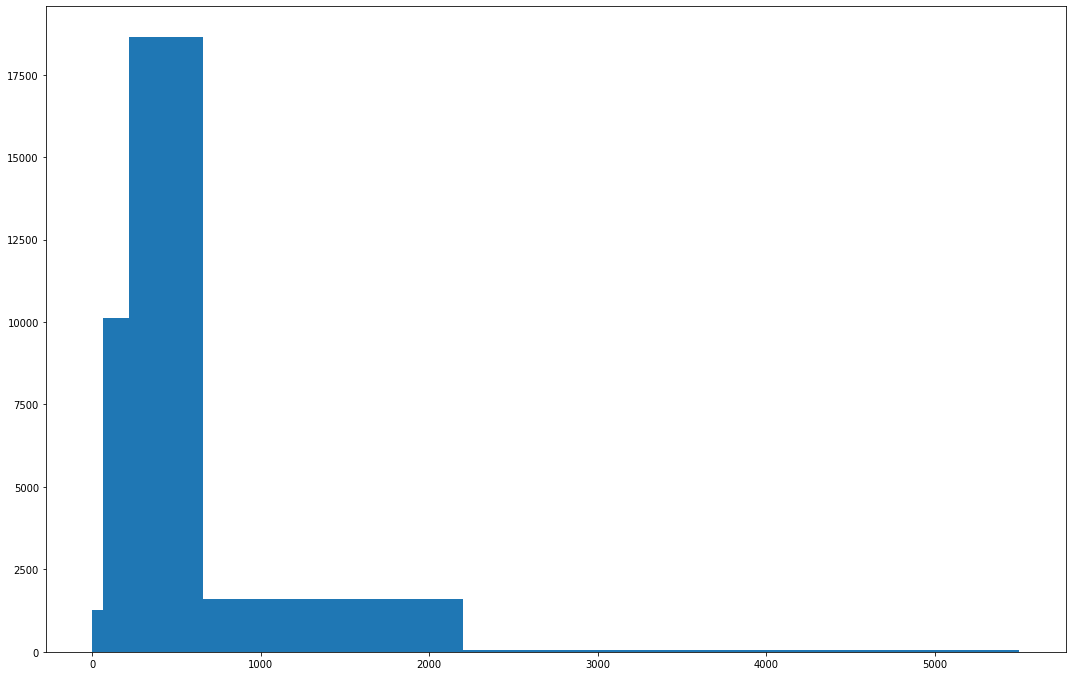

In [55]:
edges = [0,65,220,660,2200,5500]
(n, bins, patches) = plt.hist(df['ppb'], bins=edges, label='hst')
sumn = np.sum(n)
n2 = np.round(n/sumn,3)*100



print('n:',n)

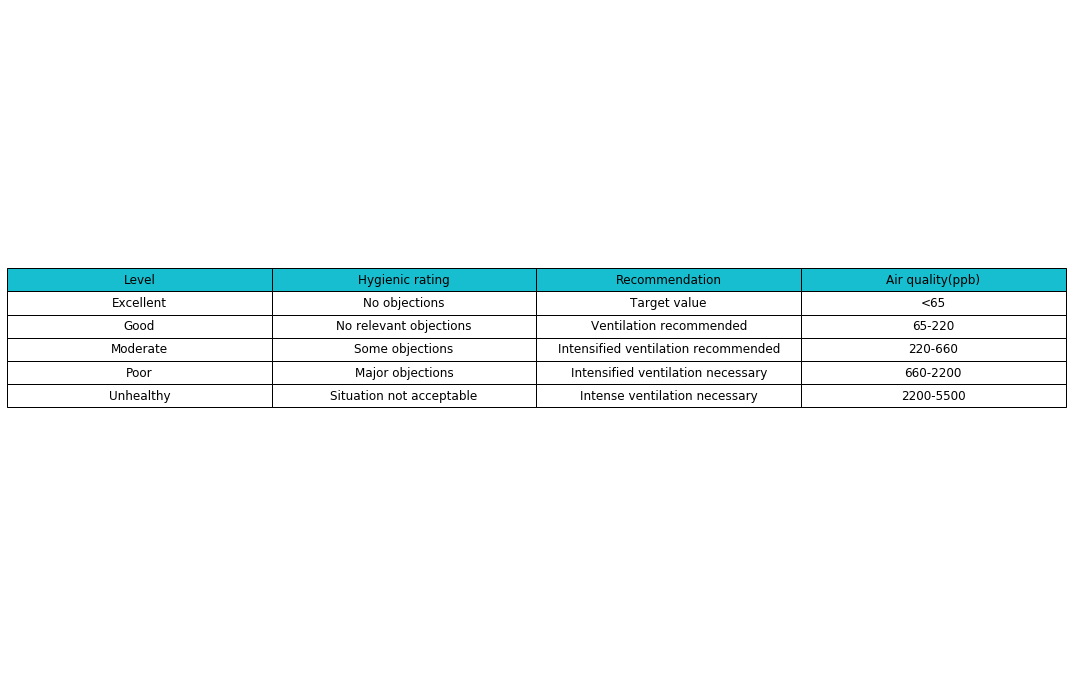

In [58]:
aq = [['Excellent','No objections','Target value','<65'],
      ['Good','No relevant objections','Ventilation recommended','65-220'],
      ['Moderate','Some objections','Intensified ventilation recommended','220-660'],
      ['Poor','Major objections','Intensified ventilation necessary','660-2200'],
      ['Unhealthy','Situation not acceptable','Intense ventilation necessary','2200-5500']]
columns = ('Level', 'Hygienic rating', 'Recommendation', 'Air quality(ppb)')
rows = ['1','2','3','4','5']



plt.rcParams["figure.figsize"] = [15.00, 9.50]
plt.rcParams["figure.autolayout"] = True

fig, ax = plt.subplots()
colors = plt.cm.BuPu(np.linspace(0, 0.5, len(rows)))
# hide axes
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')


the_table = ax.table(cellText=aq,  colColours=['tab:cyan','tab:cyan','tab:cyan','tab:cyan'],cellLoc='center',colLabels=columns, loc='center')
the_table.auto_set_font_size(False)
# the_table.auto_set_column_width(col=list(range(len(columns))))
the_table.set_fontsize(12)
the_table.scale(1, 1.5)

# plt.title('Air quality values within ranges')
# fig.tight_layout()

In [59]:
d={}
for i in range(0,len(edges)-1):
    d[str(edges[i])+' - '+str(edges[i+1])+' ppb'] = [str(int(n[i])),str(np.round(n2[i],3))+' %']
stats = pd.DataFrame.from_dict(d,orient='index')
stats.columns=['Number of occurrences','Percentage']
stats

,Number of occurrences,Percentage
0 - 65 ppb,1265,4.0 %
65 - 220 ppb,10123,32.0 %
220 - 660 ppb,18641,58.9 %
660 - 2200 ppb,1587,5.0 %
2200 - 5500 ppb,45,0.1 %


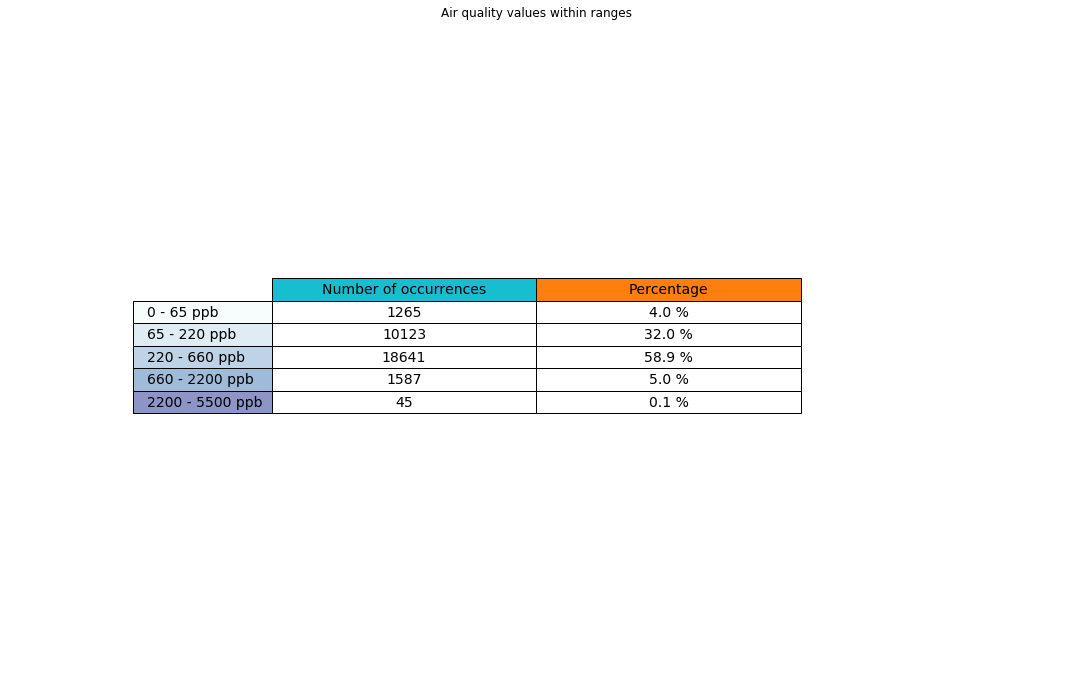

In [60]:
plt.rcParams["figure.figsize"] = [15.00, 9.50]
plt.rcParams["figure.autolayout"] = True
fig, ax = plt.subplots()
colors = plt.cm.BuPu(np.linspace(0, 0.5, len(rows)))
# hide axes
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')


the_table = ax.table(cellText=stats.values, colColours=['tab:cyan','tab:orange'],rowColours=colors,rowLabels = stats.index, cellLoc='center',colLabels=stats.columns, loc='center',fontsize=16)
the_table.auto_set_font_size(False)
# the_table.auto_set_column_width(col=list(range(len(columns))))
the_table.set_fontsize(14)
the_table.scale(0.5, 1.5)
plt.title('Air quality values within ranges')
fig.tight_layout()


In [84]:
devname = '000.888.000133'
descriptors = 'bindc,illu'

# get devid by serial name
r1 = requests.get(
    url=address + "/api/tenant/devices?deviceName=" + devname,
    headers={'Content-Type': 'application/json', 'Accept': '*/*', 'X-Authorization': acc_token}).json()

devid = r1['id']['id']

df2 = read_data(devid, acc_token, address, start_time, end_time, descriptors)

df2 = df2.resample('1T').max()
df2['ts'] = df2.index
df2['ts'] = df2['ts'].dt.tz_localize('utc').dt.tz_convert('Europe/Athens')
df2.set_index('ts',inplace=True,drop=True)
df2 = df2.fillna(method='ffill')
df2 = df2.dropna()
df2['day'] = df2.index.weekday
df2['hour'] = df2.index.hour
# df2 = df2.loc[df2['day']<5]
# df2 = df2.loc[(df2['hour']<=15) & (df2['hour']>=8)]

df2.drop(['day','hour'],axis=1,inplace=True)



In [85]:
df = pd.concat([df,df2],axis=1)
df.rename(columns={'bindc':'Motion','illu':'Illuminance','tmp':'Temperature','hmd':'Humidity','ppb':'Air quality'},inplace=True)
df = df.dropna()
df = df.resample('5T').agg({'Air quality':np.max,'Temperature':np.max,'Humidity':np.max,'Motion':np.sum,'Illuminance':np.max})
df = df.dropna()

In [87]:
# get weather data from Soda Merra


def my_to_datetime(date_str):
    if date_str[11:13] != '24':
        return pd.to_datetime(date_str, format = '%Y-%m-%d %H:%M:%S')

    date_str = date_str[0:11] + '00' + date_str[13:]
    return pd.to_datetime(date_str, format = '%Y-%m-%d %H:%M:%S') + timedelta(days=1)



merra = pd.DataFrame([])
# start_date = '2021-06-14'
# end_date='2021-07-15'
start_date = '2021-05-09' 
end_date = '2021-06-01'
lat = '37.90543250457023'
lon = '23.742231952930744'
r= requests.get('http://www.soda-pro.com/portlets-common/cgi-bin/proxy.py?url=http%3A%2F%2Fwww.soda-is.com%2Fcom%2Fmerra2.php%3Flatlon%3D'+str(lat)+'%252C'+str(lon)+'%26date1%3D'+str(start_date)+'%26date2%3D'+str(end_date)+'%26summar%3D5%26outcsv%3D1')
match = re.search(r'http://.+?\.csv', str(r.content))
url = match.group()
r2 = requests.get(url)
c = r2.content

soup = BeautifulSoup(c,'html5lib')

body = soup.find('body')
data=[]
rows =body.get_text(strip=True) 
data.append(rows)
list2 = []
list2= data[0].split('\n')
list2 = list2[24:]

for i in range(0,len(list2)):
    list2[i] = list2[i].split(';')
headers = list2.pop(0)
merra = pd.DataFrame(list2, columns=headers)
merra['UT time'] = merra['UT time']+':00'

merra['# Date'] = (merra['# Date']+' '+merra['UT time'])
merra['Date'] = merra['# Date'].apply(my_to_datetime)

merra['ts'] = merra['Date'].dt.tz_localize('utc').dt.tz_convert('Europe/Athens')
merra.drop(['# Date','Date','UT time','Wind direction','Rainfall','Snowfall','Snow depth','Relative Humidity'],axis=1,inplace=True)
merra.set_index('ts',inplace=True,drop=True)
for col in merra.columns:
    merra[col] = merra[col].astype('float')
    
# merra['External Temperature'] = merra['Temperature'].apply(pytemperature.k2c)
merra.drop('Temperature',axis=1,inplace=True)
merra = merra[:end_date]

merra.head()

AttributeError: 'NoneType' object has no attribute 'group'

In [64]:
df = pd.merge(df, merra, how ='inner',left_index=True, right_index=True)
df.head()

,Air quality,Temperature,Humidity,Motion,Illuminance,Pressure,Wind speed,Short-wave irradiation
ts,,,,,,,,
2021-05-10 00:05:00+03:00,11.0,25.1,35.9,0.0,6473.0,1007.74,6.91,0.0
2021-05-10 00:10:00+03:00,11.0,25.1,35.9,0.0,6473.0,1007.72,6.91,0.0
2021-05-10 00:15:00+03:00,13.0,25.1,36.0,0.0,6473.0,1007.70,6.91,0.0
2021-05-10 00:20:00+03:00,13.0,25.1,36.0,0.0,6446.0,1007.67,6.91,0.0
2021-05-10 00:25:00+03:00,11.0,25.1,36.0,0.0,6453.0,1007.65,6.91,0.0


In [43]:
# fig = plt.figure(figsize=[12,8])
# plt.plot(df['Temperature'])
# # plt.plot(df['Air quality'])
# fig = plt.figure(figsize=[12,8])

# plt.plot(df['Air quality'])

Text(0.5, 1, 'Correlation heatmap - Values greater than 0.5 indicate strong correlation')

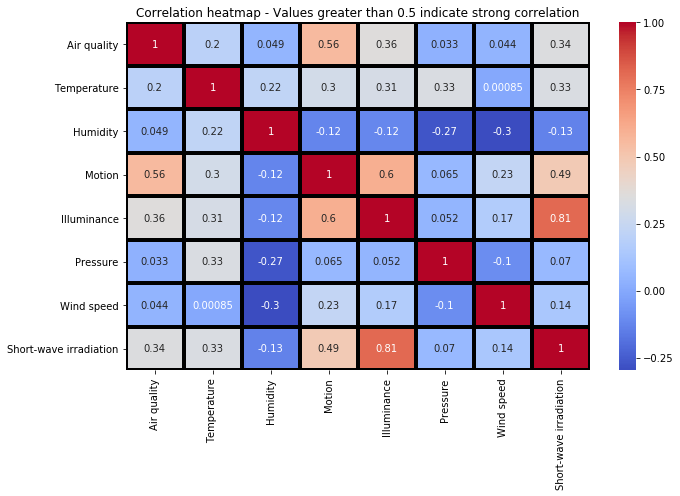

In [67]:
import seaborn as sns
tmp = df.resample('15T').mean()
fig = plt.figure(figsize=[10,7])
ax = sns.heatmap(tmp.loc[tmp['Air quality']>220].corr(), annot = True,cmap= 'coolwarm',linewidths=3, linecolor='black')
# ax = sns.heatmap(df.corr(), annot = True,cmap= 'coolwarm',linewidths=3, linecolor='black')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.set_title('Correlation heatmap - Values greater than 0.5 indicate strong correlation')


Text(6.800000000000001, 0.5, 'Days of month')

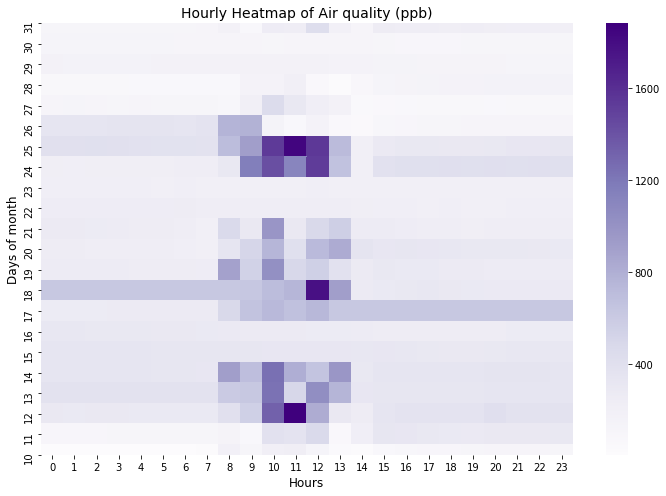

In [36]:
import calendar
hm = df.resample('1H').mean().copy()
#df.reset_index(drop = False, inplace = True)
hm['hour'] = hm.index.hour
month = calendar.month_name[hm.index[0].month]

hm = pd.pivot_table(hm, 'Air quality', hm.index.day, 'hour')
# hm=hm.T
hm = hm.sort_index(ascending=False)
fig, ax = plt.subplots(figsize=(10, 7.0))
sns.heatmap(hm, cmap="Purples")
plt.title('Hourly Heatmap of Air quality (ppb)',fontsize=14)
plt.xlabel('Hours',fontsize=12)
plt.ylabel('Days of month',fontsize=12)

In [20]:
# hm = df.resample('1H').mean().copy()
# #df.reset_index(drop = False, inplace = True)
# hm['hour'] = hm.index.hour
# month = calendar.month_name[hm.index[0].month]

# hm = pd.pivot_table(hm, 'Temperature', hm.index.day, 'hour')
# # hm=hm.T
# hm = hm.sort_index(ascending=False)
# fig, ax = plt.subplots(figsize=(12, 8.0))
# sns.heatmap(hm, cmap="Oranges")
# plt.title('Heatmap of Temperature',fontsize=14)
# plt.xlabel('Hours')
# plt.ylabel('Days of month')

In [12]:
df.head()

,Air quality,Temperature,Humidity,Motion,Illuminance,Pressure,Wind speed,Short-wave irradiation,External Temperature
ts,,,,,,,,,
2021-05-10 00:05:00+03:00,11.0,25.1,35.9,0.0,6473.0,1007.74,6.91,0.0,14.54
2021-05-10 00:10:00+03:00,11.0,25.1,35.9,0.0,6473.0,1007.72,6.91,0.0,14.52
2021-05-10 00:15:00+03:00,13.0,25.1,36.0,0.0,6473.0,1007.70,6.91,0.0,14.51
2021-05-10 00:20:00+03:00,13.0,25.1,36.0,0.0,6446.0,1007.67,6.91,0.0,14.50
2021-05-10 00:25:00+03:00,11.0,25.1,36.0,0.0,6453.0,1007.65,6.91,0.0,14.48


In [ ]:
from scipy.stats import pearsonr

import pandas as pd

def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 4)
    return pvalues



In [11]:
lagged_correlation = pd.DataFrame.from_dict(
    {x: [df['Air quality'].corr(df[x].shift(-t)) for t in range(10)] for x in df.columns})
lagged_correlation

,Air quality,Temperature,Humidity,Motion,Illuminance,Pressure,Wind speed,Short-wave irradiation,External Temperature
0,1.000000,-0.068929,0.058436,0.405250,0.311370,-0.014918,-0.066407,0.284139,0.195245
1,0.934391,-0.066557,0.060862,0.395494,0.308763,-0.015257,-0.067408,0.290016,0.200979
2,0.851690,-0.065134,0.060138,0.388466,0.305883,-0.015641,-0.068379,0.295679,0.206602
3,0.783783,-0.063834,0.056658,0.370907,0.302700,-0.016080,-0.069329,0.301114,0.212109
4,0.729646,-0.062882,0.051813,0.345642,0.299398,-0.016579,-0.070240,0.306315,0.217507
5,0.686997,-0.062366,0.045377,0.322519,0.295902,-0.017143,-0.071124,0.311269,0.222774
6,0.656543,-0.062179,0.038364,0.300221,0.292319,-0.017762,-0.071949,0.315982,0.227901
7,0.634549,-0.062934,0.031230,0.279880,0.288625,-0.018421,-0.072675,0.320471,0.232869
8,0.618946,-0.063768,0.023870,0.273850,0.285017,-0.019112,-0.073338,0.324759,0.237708
9,0.603495,-0.064696,0.017651,0.282280,0.281429,-0.019851,-0.073932,0.328827,0.242414
